Epoch 1/10 - loss: 0.4216 - acc: 0.8703 - val_loss: 0.1736 - val_acc: 0.9468
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 2/10 - loss: 0.1859 - acc: 0.9446 - val_loss: 0.1243 - val_acc: 0.9632
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 3/10 - loss: 0.1399 - acc: 0.9587 - val_loss: 0.1089 - val_acc: 0.9677
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 4/10 - loss: 0.1136 - acc: 0.9649 - val_loss: 0.1016 - val_acc: 0.9710
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 5/10 - loss: 0.0979 - acc: 0.9704 - val_loss: 0.0929 - val_acc: 0.9740
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 6/10 - loss: 0.0880 - acc: 0.9728 - val_loss: 0.0897 - val_acc: 0.9760
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 7/10 - loss: 0.0778 - acc: 0.9764 - val_loss: 0.0884 - val_acc: 0.9761
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 8/10 - loss: 0.0706 - acc: 0.9788 - val_loss: 0.0894 - val_acc: 0.9763
Epoch 9/10 - loss: 0.0650 - acc: 0.9801 - val_loss: 0.0824 - val_acc: 0.9792
INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


INFO:tensorflow:Assets written to: checkpoint_path_tf_only\assets


Epoch 10/10 - loss: 0.0631 - acc: 0.9814 - val_loss: 0.0842 - val_acc: 0.9778


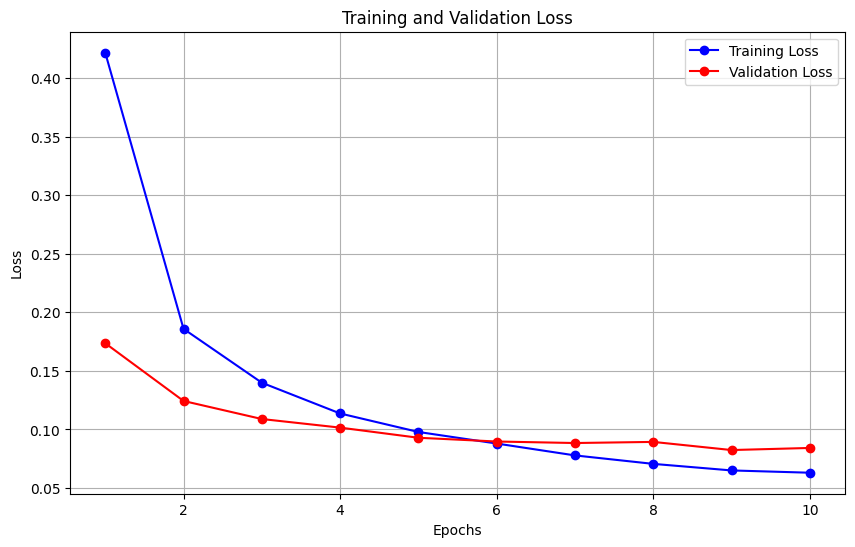

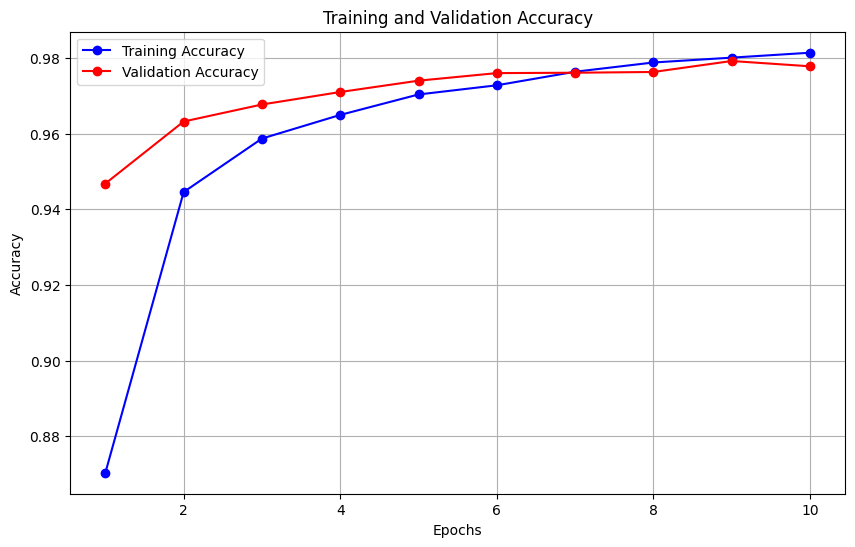

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import os

# ====== Dataset ======
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

# ====== Model ======
class MNISTModel(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.W1 = tf.Variable(tf.random.normal([784, 512], stddev=0.1), name="W1")
        self.b1 = tf.Variable(tf.zeros([512]), name="b1")
        self.W2 = tf.Variable(tf.random.normal([512, 10], stddev=0.1), name="W2")
        self.b2 = tf.Variable(tf.zeros([10]), name="b2")

    @tf.function
    def __call__(self, inputs, training=False):
        x = tf.matmul(inputs, self.W1) + self.b1
        x = tf.nn.relu(x)
        if training:
            x = tf.nn.dropout(x, rate=0.5)
        return tf.matmul(x, self.W2) + self.b2

    @property
    def trainable_variables(self):
        return [self.W1, self.b1, self.W2, self.b2]

# ====== Loss & Metrics ======
def loss_fn(y_true, logits):
    y_true = tf.cast(y_true, tf.int64)
    return tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=logits)
    )

def accuracy_fn(y_true, logits):
    preds = tf.argmax(tf.nn.softmax(logits), axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(preds, tf.cast(y_true, tf.int64)), tf.float32))

# ====== Optimizer (RMSprop thủ công) ======
class RMSpropOptimizer:
    def __init__(self, lr=0.001, rho=0.9, epsilon=1e-7):
        self.lr, self.rho, self.eps = lr, rho, epsilon
        self.states = {}

    def apply_gradients(self, grads_and_vars):
        for g, v in grads_and_vars:
            vid = id(v)
            if vid not in self.states:
                self.states[vid] = tf.Variable(tf.zeros_like(v))
            s = self.states[vid]
            new_s = self.rho * s + (1 - self.rho) * tf.square(g)
            self.states[vid].assign(new_s)
            v.assign_sub(self.lr * g / (tf.sqrt(new_s) + self.eps))

# ====== Callbacks ======
class EarlyStopping:
    def __init__(self, monitor="val_accuracy", patience=2):
        self.monitor = monitor
        self.patience = patience
        self.best = -np.inf
        self.wait = 0
        self.stopped_epoch = None
        self.stop_training = False

    def on_epoch_end(self, epoch, logs):
        current = logs[self.monitor]
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop_training = True
                self.stopped_epoch = epoch + 1
                print(f"Early stopping triggered at epoch {self.stopped_epoch}")

class ModelCheckpoint:
    def __init__(self, filepath="checkpoint", monitor="val_loss"):
        self.filepath = filepath
        self.monitor = monitor
        self.best = np.inf

    def on_epoch_end(self, epoch, logs, model):
        current = logs[self.monitor]
        if current < self.best:
            self.best = current
            tf.saved_model.save(model, self.filepath)

# ====== Training loop giống fit ======
def fit(model, optimizer, x_train, y_train, x_val, y_val, epochs, batch_size, callbacks):
    history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}
    num_batches = len(x_train) // batch_size

    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            loss = loss_fn(y, logits)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        acc = accuracy_fn(y, logits)
        return loss, acc

    @tf.function
    def test_step(x, y):
        logits = model(x, training=False)
        return loss_fn(y, logits), accuracy_fn(y, logits)

    for epoch in range(epochs):
        # Train loop
        epoch_loss, epoch_acc = [], []
        for i in range(num_batches):
            xb, yb = x_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            l, a = train_step(xb, yb)
            epoch_loss.append(l.numpy()); epoch_acc.append(a.numpy())

        # Validation
        val_loss, val_acc = test_step(x_val, y_val)
        logs = {
            "loss": np.mean(epoch_loss),
            "accuracy": np.mean(epoch_acc),
            "val_loss": val_loss.numpy(),
            "val_accuracy": val_acc.numpy()
        }
        history["loss"].append(logs["loss"])
        history["accuracy"].append(logs["accuracy"])
        history["val_loss"].append(logs["val_loss"])
        history["val_accuracy"].append(logs["val_accuracy"])

        # Log đẹp như fit()
        print(f"Epoch {epoch+1}/{epochs} - "
              f"loss: {logs['loss']:.4f} - acc: {logs['accuracy']:.4f} - "
              f"val_loss: {logs['val_loss']:.4f} - val_acc: {logs['val_accuracy']:.4f}")

        # Callbacks
        stop = False
        for cb in callbacks:
            if isinstance(cb, ModelCheckpoint):
                cb.on_epoch_end(epoch, logs, model)
            elif isinstance(cb, EarlyStopping):
                cb.on_epoch_end(epoch, logs)
                if cb.stop_training:
                    stop = True
        if stop:
            break
    return history

# ====== Run training ======
model = MNISTModel()
optimizer = RMSpropOptimizer(lr=0.001)
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=2),
    ModelCheckpoint(filepath="checkpoint_path_tf_only", monitor="val_loss")
]

history = fit(model, optimizer, train_images, train_labels,
              val_images, val_labels,
              epochs=10, batch_size=128, callbacks=callbacks)

# ====== Plot ======
epochs_range = range(1, len(history["loss"]) + 1)

# Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history["loss"], "bo-", label="Training Loss")
plt.plot(epochs_range, history["val_loss"], "ro-", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history["accuracy"], "bo-", label="Training Accuracy")
plt.plot(epochs_range, history["val_accuracy"], "ro-", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()